In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
plt.style.use('default')
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import NMF, PCA
from sklearn.cluster import KMeans
from sklearn.manifold import Isomap, TSNE
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import Input, Dense, TimeDistributed, Embedding, GlobalAveragePooling1D
from tensorflow.keras.utils import plot_model
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report

import requests
stopwords_list = requests.get("https://gist.githubusercontent.com/rg089/35e00abf8941d72d419224cfd5b5925d/raw/12d899b70156fd0041fa9778d657330b024b959c/stopwords.txt").content
stopwords = set(stopwords_list.decode().splitlines()) 
import os

# Aula 18: Redes Neurais ao Longo do Tempo
**Objetivo: : ao fim desta aula, o aluno será capaz de aplicar redes neurais recorrentes para agregar informações de documentos ao longo do tempo**

In [2]:
df = pd.read_csv('./datasets/IMDB Dataset.csv')
reviews = list(df['review'])

labels = np.array([list(df['sentiment'])]).T
ohe = OneHotEncoder()
y = ohe.fit_transform(labels).toarray()

# Exercício 1
*Objetivo: entender como sequências são representadas no Keras*

Um documento pode ser entendido como uma sequência de palavras.

1. Se representássemos nossa coleção como sequências de palavras, chegaríamos a uma matriz. Que significaria cada linha e coluna da matriz?

1. Como deveríamos lidar com o fato de que documentos podem ter mais ou menos palavras que a dimensão correspondente da matriz?

1. Se cada palavra for representada por um vetor de N dimensões, então nossa coleção passaria a ser representada por um tensor, que é essencialmente uma matriz 3D (na verdade, tensores podem ter várias dimensões, mas usaremos somente 3 neste caso). O que significa cada dimensão desse tensor?

1. No código de pré-processamento abaixo, o que fazem as funções `tokenizer.texts_to_sequences()` e `pad_sequences()`?


In [3]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=1000)
tokenizer.fit_on_texts(reviews)
sequences = tokenizer.texts_to_sequences(reviews)

In [4]:
print(sequences[0])

[27, 4, 1, 79, 45, 12, 100, 147, 39, 307, 398, 474, 26, 33, 23, 203, 14, 11, 6, 621, 48, 596, 16, 68, 7, 7, 1, 86, 148, 12, 68, 42, 13, 92, 2, 134, 4, 570, 60, 268, 8, 203, 36, 1, 661, 139, 68, 11, 6, 21, 3, 119, 15, 1, 38, 11, 119, 54, 16, 5, 376, 38, 570, 92, 6, 8, 1, 360, 356, 4, 1, 661, 7, 7, 9, 6, 433, 14, 12, 6, 1, 358, 5, 1, 9, 20, 538, 32, 4, 1, 117, 29, 1, 25, 2, 391, 34, 6, 21, 299, 20, 1, 538, 6, 344, 5, 106, 2, 51, 34, 327, 2, 23, 110, 225, 243, 7, 7, 10, 58, 131, 1, 280, 4, 1, 119, 6, 693, 5, 1, 192, 12, 9, 269, 117, 79, 276, 589, 834, 180, 15, 834, 834, 887, 149, 954, 183, 1, 86, 398, 10, 123, 210, 68, 14, 34, 9, 13, 10, 413, 131, 10, 13, 15, 9, 18, 14, 10, 287, 51, 10, 3, 15, 2, 189, 5, 1, 299, 4, 570, 21, 39, 570, 18, 26, 41, 15, 3, 504, 20, 642, 2, 76, 243, 16, 9, 69, 651, 710, 109, 662, 82, 693, 5, 65, 574, 4, 920, 38, 559, 147, 22, 200, 426, 16, 48, 6, 805, 43, 22, 67, 76, 8, 16, 125, 486]


In [25]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
padded = pad_sequences(sequences,maxlen=200)
padded

array([[  1,  86, 148, ...,  16, 125, 486],
       [  0,   0,   0, ...,  23,  69, 221],
       [  0,   0,   0, ...,  63,  16, 350],
       ...,
       [  0,   0,   0, ...,  16,   2,   2],
       [  0,   0,   0, ...,  67, 739,  42],
       [  0,   0,   0, ..., 794,  11,  17]], dtype=int32)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(padded, y, test_size=0.2)   

# Exercício 2
*Objetivo: explicar uma rede neural à partir de sua representação gráfica*

Nesta aula, usaremos a camada `embedding`. A camada `embedding` relaciona cada palavra a uma posição em um espaço vetorial – como se estivéssemos multiplicando uma representação one-hot encoding das palavras por uma matriz. A diferença entre a matriz e o embedding é que a camada embedding faz essa transformação através de um dicionário cuja chave é a palavra e o conteúdo é a representação vetorial correspondente.

Veja o código da implementação `rede_neural_classificar_por_palavra` abaixo. Se precisar, use a documentação do Keras para responder:

1. O que a camada `GlobalAveragePooling1D` faz? Em que dimensão (documentos, dimensões latentes ou tempo) ela opera?
1. Esta rede é semelhante a qual outra rede que já trabalhamos nesta disciplina?
1. O que esperamos encontrar no espaço latente desta rede?

2022-05-10 16:32:41.792272: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-10 16:32:42.038060: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-10 16:32:42.039744: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-10 16:32:42.042286: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

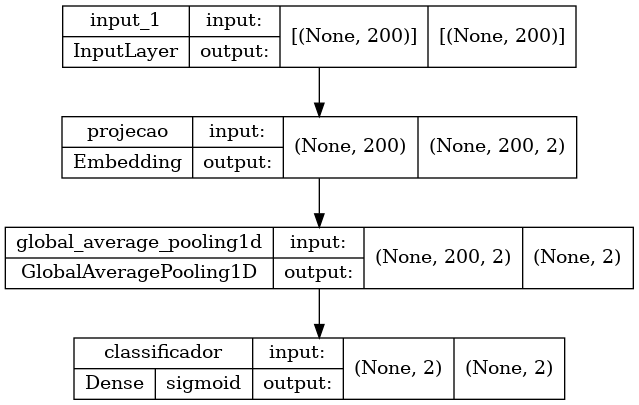

In [7]:
def rede_neural_classificar_por_palavra(input_dims, n_dims_out):
  input_layer = Input(shape=(input_dims,))
  x = input_layer
  x = Embedding(1000, 2, name='projecao')(x)
  x = GlobalAveragePooling1D()(x)
  y = Dense(2, activation='sigmoid', name='classificador')(x)
  return Model(input_layer, y)

rede_neural = rede_neural_classificar_por_palavra(200, 2)
rede_neural.compile(optimizer='adam', loss='mse')
plot_model(rede_neural, show_shapes=True, show_layer_activations=True)

# Exercício 3
*Objetivo: aplicar uma rede neural com camada embedding e interpretar os resultados*

Execute o treino e teste da rede neural.
1. Os resultados condizem com o que você esperaria encontrar?
1. Aumente o número de dimensões do espaço latente. O desempenho da rede muda? Usando `PCA`, analise o espaço latente de mais alta dimensão. Você consegue visualizar diferenças?

In [8]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)
history = rede_neural.fit(X_train, y_train, epochs=500, validation_split=0.2, callbacks=es)

Epoch 1/500
1000/1000 [==============================] - 4s 3ms/step - loss: 0.2423 - val_loss: 0.2292
Epoch 2/500
1000/1000 [==============================] - 2s 2ms/step - loss: 0.2108 - val_loss: 0.1947
Epoch 3/500
1000/1000 [==============================] - 2s 2ms/step - loss: 0.1797 - val_loss: 0.1685
Epoch 4/500
1000/1000 [==============================] - 2s 2ms/step - loss: 0.1574 - val_loss: 0.1494
Epoch 5/500
1000/1000 [==============================] - 2s 2ms/step - loss: 0.1417 - val_loss: 0.1367
Epoch 6/500
1000/1000 [==============================] - 2s 2ms/step - loss: 0.1308 - val_loss: 0.1274
Epoch 7/500
1000/1000 [==============================] - 2s 2ms/step - loss: 0.1229 - val_loss: 0.1207
Epoch 8/500
1000/1000 [==============================] - 2s 2ms/step - loss: 0.1170 - val_loss: 0.1160
Epoch 9/500
1000/1000 [==============================] - 2s 2ms/step - loss: 0.1125 - val_loss: 0.1121
Epoch 10/500
1000/1000 [==============================] - 2s 2ms/step - l

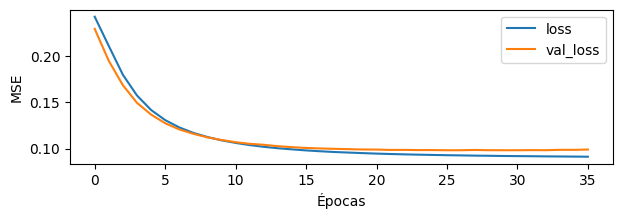

In [9]:
plt.figure(figsize=(7,2))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Épocas')
plt.ylabel('MSE')
plt.legend()
plt.show()

In [10]:
y_est = rede_neural.predict(X_test)
print(classification_report(ohe.inverse_transform(y_test), ohe.inverse_transform(y_est)))

              precision    recall  f1-score   support

    negative       0.88      0.86      0.87      4967
    positive       0.86      0.88      0.87      5033

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



## Analisando layer de Embedding

In [11]:
w = rede_neural.get_layer('projecao').get_weights()

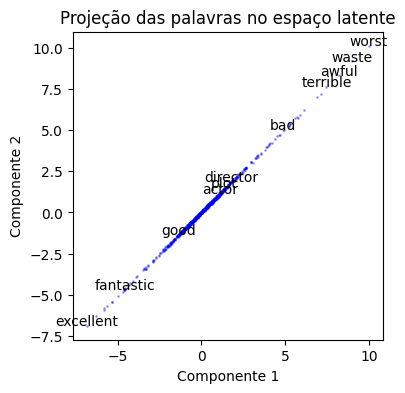

In [12]:
w = rede_neural.get_layer('projecao').get_weights()
# Visualização: onde foi parar cada palavra?
v_ = rede_neural.get_layer('projecao').get_weights()[0]

#proj = PCA(n_components=2, perplexity=5)
#v = proj.fit_transform(v_)
v = v_

plt.figure(figsize=(4,4))
plt.scatter(v[:,0], v[:,1], s=1, alpha=0.3, c='b')
for s in ["director", "actor", "bad", "good", "excellent", "plot", "worst", "terrible", "waste", "awful", "fantastic"]:
    _n = tokenizer.texts_to_sequences([[s]])[0][0]
    plt.text(v[_n,0], v[_n,1], s, ha='center')
plt.title('Projeção das palavras no espaço latente')
plt.ylabel('Componente 2')
plt.xlabel('Componente 1')
#plt.xlim([-20,20])
#plt.ylim([-20,20])
plt.show()

# Exercício 4
*Objetivo: entender como uma rede recorrente opera no domínio do tempo*

1. Uma rede neural recorrente aplica alguma variação da equação:
$$
y[t] = f( [x[t], y[t-1]])
$$

Isso significa que uma de suas entradas é a saída na interação anterior.

Desenhe um diagrama de blocos mostrando esse comportamento.

1. A rede recorrente opera no domínio do tempo. Trata-se de um tempo "discreto", ou seja, existe t=1, t=2, t=3, etc. No caso da frase "frase de teste", quantos "tempos discretos" devem existir?

1. A rede neural recorrente recebe como entradas a entrada de fato (dados) e também a saída que foi gerada na iteração anterior. Por que não é possível usar como entrada a saída da iteração atual?

1. Podemos dizer que esse tipo de rede tem algum tipo de "memória" quanto ao passado? Como isso se relaciona a modelos do tipo n-grama?

1. De acordo com o diagrama de blocos, a rede emite uma saída para cada instante de tempo. No nosso caso, isso significa uma saída para cada palavra da frase. Consulte a documentação do Keras e encontre: como o bloco `SimpleRNN` pode retornar uma única saída para cada documento, isto é, como a dimensão do tempo é eliminada?



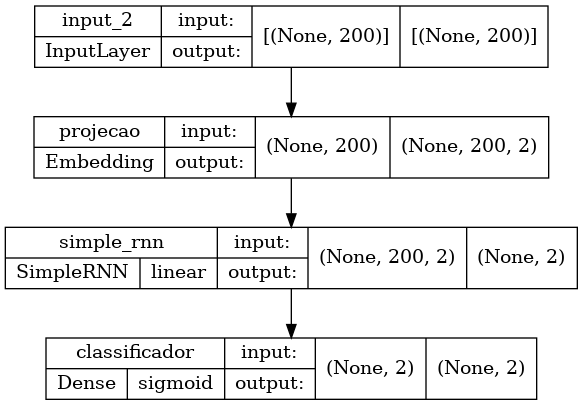

In [13]:
from keras.layers import SimpleRNN
def rede_neural_com_RNN(input_dims, n_dims_out):
  input_layer = Input(shape=(input_dims,))
  x = input_layer
  x = Embedding(1000, 2, name='projecao')(x)
  x = SimpleRNN(2, activation='linear')(x)
  y = Dense(2, activation='sigmoid', name='classificador')(x)
  return Model(input_layer, y)

rede_neural = rede_neural_com_RNN(200, 2)
rede_neural.compile(optimizer='adam', loss='mse')
plot_model(rede_neural, show_shapes=True, show_layer_activations=True)

# Exercício 5
*Objetivo: avaliar uma rede neural recorrente para o problema de classificação de sentimentos em avaliações de filmes*

Avalie a rede neural recorrente presente no notebook. Como ela se comporta em relação ao:

1. Desempenho nas métricas usuais
1. Propriedades do espaço latente



In [14]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)
history = rede_neural.fit(X_train, y_train, epochs=500, validation_split=0.2, callbacks=es)

Epoch 1/500
1000/1000 [==============================] - 99s 98ms/step - loss: 0.1588 - val_loss: 0.1066
Epoch 2/500
1000/1000 [==============================] - 98s 98ms/step - loss: 0.1020 - val_loss: 0.1016
Epoch 3/500
1000/1000 [==============================] - 95s 95ms/step - loss: 0.0981 - val_loss: 0.0992
Epoch 4/500
1000/1000 [==============================] - 93s 93ms/step - loss: 0.0970 - val_loss: 0.1003
Epoch 5/500
1000/1000 [==============================] - 94s 94ms/step - loss: 0.0957 - val_loss: 0.1004
Epoch 6/500
1000/1000 [==============================] - 94s 94ms/step - loss: 0.0958 - val_loss: 0.1038
Epoch 7/500
1000/1000 [==============================] - 94s 94ms/step - loss: 0.0953 - val_loss: 0.1011
Epoch 8/500
1000/1000 [==============================] - 94s 94ms/step - loss: 0.0952 - val_loss: 0.1033
Epoch 9/500
1000/1000 [==============================] - 95s 95ms/step - loss: 0.0956 - val_loss: 0.1011
Epoch 10/500
1000/1000 [==============================]

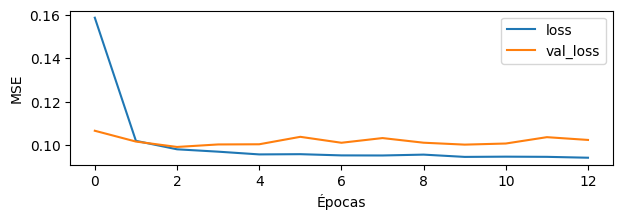

In [15]:
plt.figure(figsize=(7,2))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Épocas')
plt.ylabel('MSE')
plt.legend()
plt.show()

In [16]:
y_est = rede_neural.predict(X_test)
print(classification_report(ohe.inverse_transform(y_test), ohe.inverse_transform(y_est)))

              precision    recall  f1-score   support

    negative       0.88      0.86      0.87      4967
    positive       0.86      0.88      0.87      5033

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



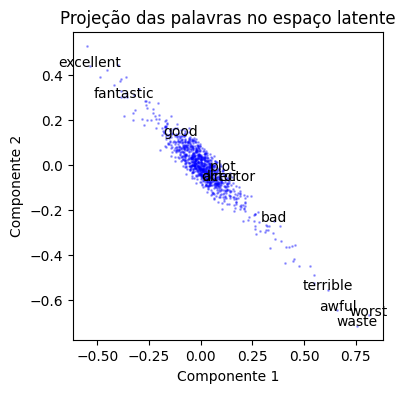

In [17]:
# Visualização 2: onde foi parar cada palavra?
v_ = rede_neural.get_layer('projecao').get_weights()[0]

#proj = PCA(n_components=2, perplexity=5)
#v = proj.fit_transform(v_)
v = v_

plt.figure(figsize=(4,4))
plt.scatter(v[:,0], v[:,1], s=1, alpha=0.3, c='b')
for s in ["director", "actor", "bad", "good", "excellent", "plot", "worst", "terrible", "waste", "awful", "fantastic"]:
    _n = tokenizer.texts_to_sequences([[s]])[0][0]
    plt.text(v[_n,0], v[_n,1], s, ha='center')
plt.title('Projeção das palavras no espaço latente')
plt.ylabel('Componente 2')
plt.xlabel('Componente 1')
#plt.xlim([-20,20])
#plt.ylim([-20,20])
plt.show()

# Exercício 6
*Objetivo: usar embeddings pré-treinados*

Fonte: [Jeffrey Pennington, Richard Socher, and Christopher D. Manning. 2014. GloVe: Global Vectors for Word Representation](https://nlp.stanford.edu/projects/glove/)

1. Em nosso espaço latente, criado pela propagação do gradiente no problema de classificação, o que a posição de uma palavra pode nos informar sobre ela?

1. Seria possível "emprestar" o embedding criado em um outro processo de classificação, e então treinar somente a etapa de classificação em seu problema específico?

1. Um espaço latente muito usado hoje é o GloVe. Ele foi criado por uma equipe de Stanford e tem duas propriedades muito interessantes. As duas propriedades estão discutidas no seu [website](https://nlp.stanford.edu/projects/glove/). Quais são essas propriedades e como elas se assemelham ao que já estudamos neste curso?

# Exercício 7
*Objetivo: usar e interpretar um classificador que use embeddings pré-treinados de GloVe*

Analise e execute a rede neural que usa embeddings GloVe.
1. Como ela se compara com as anteriores?
1. O que significa o parâmetro `trainable=False` da camada de embedding?
1. Como se comporta o espaço latente de GloVe em relação às palavras que usamos? Como devemos interpretar esse espaço latente?


In [18]:
# Abrindo os embeddings GloVe
f = open("./datasets/glove.6B.100d.txt", encoding="utf8")
embeddings_index = dict()
for line in f:
    try:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    except:
        continue
f.close()


In [19]:
# Reconstruindo a matriz de embeddings (para carregar na camada embedding)
word_index = tokenizer.word_index
embedding_matrix = np.zeros((len(word_index) + 1, 100))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector


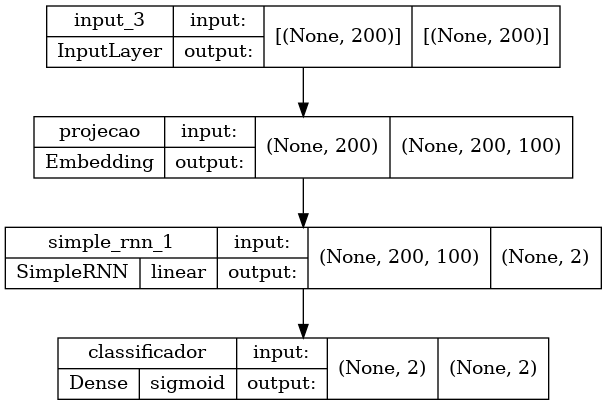

In [20]:
from keras.layers import SimpleRNN
def rede_neural_com_Glove(input_dims, n_dims_out):
  input_layer = Input(shape=(input_dims,))
  x = input_layer
  x = Embedding(len(word_index) + 1, 100, name='projecao', weights=[embedding_matrix], trainable=False)(x)
  x = SimpleRNN(2, activation='linear')(x)
  y = Dense(2, activation='sigmoid', name='classificador')(x)
  return Model(input_layer, y)

rede_neural = rede_neural_com_Glove(200, 2)
rede_neural.compile(optimizer='adam', loss='mse')
plot_model(rede_neural, show_shapes=True, show_layer_activations=True)

In [21]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)
history = rede_neural.fit(X_train, y_train, epochs=500, validation_split=0.2, callbacks=es)

Epoch 1/500
1000/1000 [==============================] - 76s 76ms/step - loss: 0.2458 - val_loss: 0.2120
Epoch 2/500
1000/1000 [==============================] - 76s 76ms/step - loss: 0.1814 - val_loss: 0.1842
Epoch 3/500
1000/1000 [==============================] - 76s 76ms/step - loss: 0.1721 - val_loss: 0.1721
Epoch 4/500
1000/1000 [==============================] - 75s 75ms/step - loss: 0.1672 - val_loss: 0.1634
Epoch 5/500
1000/1000 [==============================] - 76s 76ms/step - loss: 0.1649 - val_loss: 0.1591
Epoch 6/500
1000/1000 [==============================] - 78s 78ms/step - loss: 0.1634 - val_loss: 0.1661
Epoch 7/500
1000/1000 [==============================] - 76s 76ms/step - loss: 0.1613 - val_loss: 0.1547
Epoch 8/500
1000/1000 [==============================] - 76s 76ms/step - loss: 0.1613 - val_loss: 0.1574
Epoch 9/500
1000/1000 [==============================] - 76s 76ms/step - loss: 0.1605 - val_loss: 0.1559
Epoch 10/500
1000/1000 [==============================]

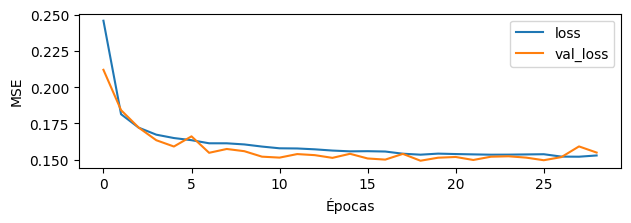

In [22]:
plt.figure(figsize=(7,2))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Épocas')
plt.ylabel('MSE')
plt.legend()
plt.show()

In [23]:
y_est = rede_neural.predict(X_test)
print(classification_report(ohe.inverse_transform(y_test), ohe.inverse_transform(y_est)))

              precision    recall  f1-score   support

    negative       0.80      0.74      0.77      4967
    positive       0.76      0.82      0.79      5033

    accuracy                           0.78     10000
   macro avg       0.78      0.78      0.78     10000
weighted avg       0.78      0.78      0.78     10000



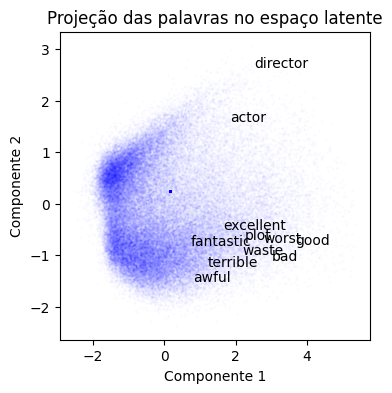

In [24]:
# Visualização 2: onde foi parar cada palavra?
v_ = rede_neural.get_layer('projecao').get_weights()[0]

proj = PCA(n_components=2)
v = proj.fit_transform(v_)


plt.figure(figsize=(4,4))
plt.scatter(v[:,0], v[:,1], s=1, alpha=0.01, c='b')
for s in ["director", "actor", "bad", "good", "excellent", "plot", "worst", "terrible", "waste", "awful", "fantastic"]:
    _n = tokenizer.texts_to_sequences([[s]])[0][0]
    plt.text(v[_n,0], v[_n,1], s, ha='center')
plt.title('Projeção das palavras no espaço latente')
plt.ylabel('Componente 2')
plt.xlabel('Componente 1')
#plt.xlim([-20,20])
#plt.ylim([-20,20])
plt.show()

# Exercício 8
*Objetivo: avaliar se a rede recorrente está usando informações de tempo*

Você deve ter observado que usar redes recorrentes é bem mais demorado que usar somente `GlobalAveragePooling1D` ou mesmo que usar as matrizes de DF que usamos na aula anterior. Essa desvantagem pode se compensar: é comum encontrarmos argumentos que dizem que as redes recorrentes acabam conseguindo modelar um pouco da relação temporal entre as palavras. Por outro lado, é possível (ainda não verificamos) que a rede neural recorrente tenha convergido para um estado que somente replica a camada `GlobalAveragePooling1D`.

Proponha e execute um experimento capaz de verificar se o desempenho da rede neural recorrente, ao menos neste dataset, se deve ao modelamento da relação temporal entre palavras.


In [26]:
rede_neural.predict

X_test

array([[476, 526, 100, ...,  41,   4, 156],
       [  0,   0,   0, ...,  17,  26, 221],
       [  0,   0,   0, ..., 155,  80, 354],
       ...,
       [  0,   0,   0, ...,  36,  38,  10],
       [  0,   0,   0, ..., 447,  15, 247],
       [  0,   0,   0, ..., 359, 332, 373]], dtype=int32)

In [61]:
def test_phrase(phrase: str):
    test = pad_sequences(tokenizer.texts_to_sequences([phrase]),maxlen=200)
    pred = rede_neural.predict(test)
    return [phrase, ohe.inverse_transform(pred)[0][0], list(pred[0])]

phrases = ['bad food', 'not not good film' ,'this movie was not good', 'excellent soundtrack worst movie', 'worst soundtrack excellent movie', 'best actor ever i loved this actor bad food','2/10', 'i really really really like the bad acting in this movie' , 'worst food ever excellent movie', "this is a bad good movie", "this is a good bad movie", "worst movie ever excellent food"]
list(map(test_phrase, phrases))

[['bad food', 'negative', [0.63570607, 0.3642939]],
 ['not not good film', 'positive', [0.49239242, 0.50760764]],
 ['this movie was not good', 'negative', [0.5359914, 0.4640086]],
 ['excellent soundtrack worst movie', 'positive', [0.46387213, 0.53612787]],
 ['worst soundtrack excellent movie', 'positive', [0.45410436, 0.54589564]],
 ['best actor ever i loved this actor bad food',
  'positive',
  [0.4734178, 0.52658224]],
 ['2/10', 'positive', [0.47924766, 0.5207524]],
 ['i really really really like the bad acting in this movie',
  'negative',
  [0.6601584, 0.33984157]],
 ['worst food ever excellent movie', 'positive', [0.42388242, 0.5761176]],
 ['this is a bad good movie', 'negative', [0.54831123, 0.4516888]],
 ['this is a good bad movie', 'negative', [0.58634603, 0.41365397]],
 ['worst movie ever excellent food', 'negative', [0.5040118, 0.49598816]]]